# Purpose:
At the previous, the virial radius of ID=11 galaxy was wrongly calculated. That makes underestimation of satellite and subhalo populations. Even though 11th galaxy is not considered currently, I want to recalculate needed properties to include it to my sample.

# DONE

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy

In [28]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)
gals2 = pklload("../database/befo231031/01_nh_ghmatch.pickle")

In [55]:
key = 11

In [24]:
oldLG = pklload("../database/befo231031/16_LocalGroup.pickle")[key]
olderLG = pklload("../database/befo231031/11_LocalGroup.pickle")[key]
print(oldLG['sats']['id'])
print(olderLG['sats']['id'])
satdtype = oldLG['sats'].dtype

[  21  210  326  513  660  870 1039 1866]
[ 210  210  326  326  513  513  660  660  870  870 1039 1039 1866 1866]


In [5]:
scores = pklload("../database/befo231031/08_nh_scores.pickle")['take']
print(scores[key].keys())

dict_keys([1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878])


In [25]:
vac = pklload("../database/befo231031/09_value_added.pickle")
print(21 in vac['Host'])
vad = vac[(vac['Host']==11)|(vac['Host']==21)]
vad['Sat']

True


array([  21,  210,  326,  513,  660,  870, 1039, 1114, 1866, 1867, 1868,
       1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 2083,
       3057, 3058, 3059,   11,  210,  326,  513,  660,  870, 1039, 1114,
       1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876,
       1877, 1878, 2083, 3057, 3058, 3059], dtype=int32)

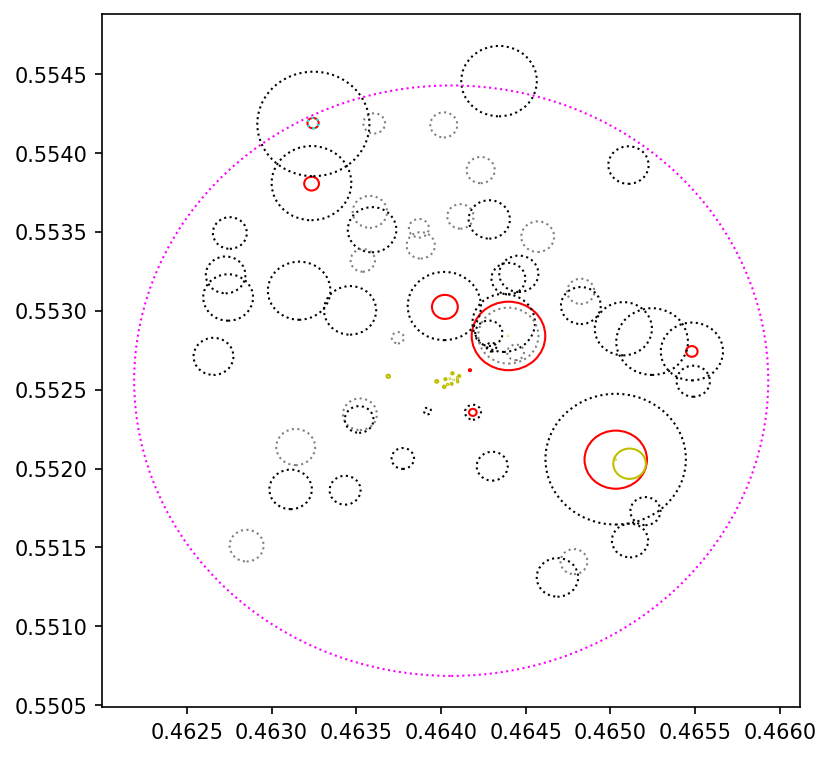

In [12]:
BGG = oldLG['BGG']
sats = cut_sphere(gals, BGG['x'], BGG['y'], BGG['z'], 1.5*BGG['r200_code'], both_sphere=True)
sats = sats[sats['id'] != BGG['id']]
subs = cut_sphere(hals, BGG['x'], BGG['y'], BGG['z'], 1.5*BGG['r200_code'], both_sphere=True, rname='rvir')
subs = subs[subs['id'] != BGG['halo_id']]

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=150)
ax.scatter(sats['x'], sats['y'], s=0, c='k')
for sat in sats:
    if(sat['id'] in oldLG['sats']['id']):
        cir = plt.Circle((sat['x'],sat['y']), sat['r'], color='r', fill=False)
    else:
        cir = plt.Circle((sat['x'],sat['y']), sat['r'], color='y', fill=False)
    ax.add_patch(cir)
for sub in subs:
    if(sub['id'] in oldLG['subs']['id']):
        cir = plt.Circle((sub['x'],sub['y']), sub['rvir'], color='k', fill=False, ls=':')
    else:
        cir = plt.Circle((sub['x'],sub['y']), sub['rvir'], color='grey', fill=False, ls=':')
    ax.add_patch(cir)

tmp = sats[sats['id'] == 326][0]
cir = plt.Circle((tmp['x'],tmp['y']), tmp['r'], color='cyan', fill=False, ls=':')
ax.add_patch(cir)
cir = plt.Circle((BGG['x'],BGG['y']), BGG['r200_code']*1.5, color='magenta', fill=False, ls=':')
ax.add_patch(cir)

# Calc Score for Satellites

See `_calc_score.py`  
output:  
  `./database/08_nh_give_scores_host0011.pickle`  
  `./database/08_nh_take_scores_host0011.pickle`  

# Calc Score for Subhalos

See `_calc_dm_score.py`  
output:  
  `./database/08_nh_give_dm_scores_host0011.pickle`  
  `./database/08_nh_take_dm_scores_host0011.pickle`  

# Check All VAD are recorded

In [16]:
print(sats['id'])
print(  np.unique(vad['Sat'])  )
ind = isin(sats['id'], np.unique(vad['Sat']))
assert ind.all()

[  21  210  326  513  660  870 1039 1114 1866 1867 1868 1869 1870 1871
 1872 1873 1874 1875 1876 1877 1878 2083 3057 3058 3059]
[  11   21  210  326  513  660  870 1039 1114 1866 1867 1868 1869 1870
 1871 1872 1873 1874 1875 1876 1877 1878 2083 3057 3058 3059]


# Make New LG(ID=11)

In [20]:
newLG = {}
newLG['BGG'] = BGG
newLG['neighbor'] = oldLG['neighbor']

In [46]:
scores = pklload(f"./08_nh_take_scores_host{BGG['id']:04d}.pickle")
dm_scores = pklload(f"./08_nh_take_dm_scores_host{BGG['id']:04d}.pickle")
def point_in_sphere(point, sphere, rname='r', factor=1):
    dist = np.sqrt( (point['x'] - sphere['x'])**2 + (point['y'] - sphere['y'])**2 + (point['z'] - sphere['z'])**2 )
    # print(dist, sphere[rname]*factor)
    return dist < sphere[rname]*factor

def sphere_in_sphere(inner, outer, r1='r',r2='r', factor=1):
    dist = np.sqrt( (inner['x'] - outer['x'])**2 + (inner['y'] - outer['y'])**2 + (inner['z'] - outer['z'])**2 )
    # print(dist+inner[r1], outer[r2])
    return (dist+inner[r1]) < outer[r2]

def sphere_touch_sphere(sph1, sph2, r1='r',r2='r', factor=1):
    dist = np.sqrt( (sph1['x'] - sph2['x'])**2 + (sph1['y'] - sph2['y'])**2 + (sph1['z'] - sph2['z'])**2 )
    # print(dist, sph1[r1]+sph2[r2])
    return dist < (sph1[r1]+sph2[r2])

In [47]:
scores.keys()

dict_keys([21, 210, 326, 513, 660, 870, 1039, 1114, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 2083, 3057, 3058, 3059])

### Real Satellites

In [48]:
goodind = np.zeros(len(sats), dtype=bool)
for i, ingal in enumerate(sats):
    try: # For satellite
        assert ingal['id'] in scores.keys()
        goodind[i] = np.median(scores[ingal['id']]%1) > 0.15
    except: # For neighbor BGG
        print(f"\t! {ingal['id']} is not in myscore.keys()")
        goodind[i] = True
leng = np.sum(goodind)
goodsats = sats[goodind]


newsats = np.empty(leng, dtype=satdtype)
for i, goodsat in enumerate(goodsats):
    tvac = vac[vac['Sat'] == goodsat['id']][0]
    for iname in satdtype.names:
        if(iname in gals.dtype.names):
            newsats[i][iname] = goodsat[iname]
        elif(iname in gals2.dtype.names):
            newsats[i][iname] = gals2[goodsat['id']-1][iname]
        elif(iname in vac.dtype.names):
            newsats[i][iname] = tvac[iname]
newLG['sats'] = newsats

### Real Subhalos

In [49]:
goodind = np.zeros(len(subs), dtype=bool)
goodind[:] = False
for i, inhal in enumerate(subs):
    try: # For subhalo
        assert inhal['id'] in dm_scores.keys()
        goodind[i] = np.median(dm_scores[inhal['id']]%1) > 0.25
    except: # For neighbor BGG
        print(f"\t! {inhal['id']} is not in myscore.keys()")
        goodind[i] = True
leng = np.sum(goodind)
goodsubs = subs[goodind]
newsubs = goodsubs
newLG['subs'] = newsubs

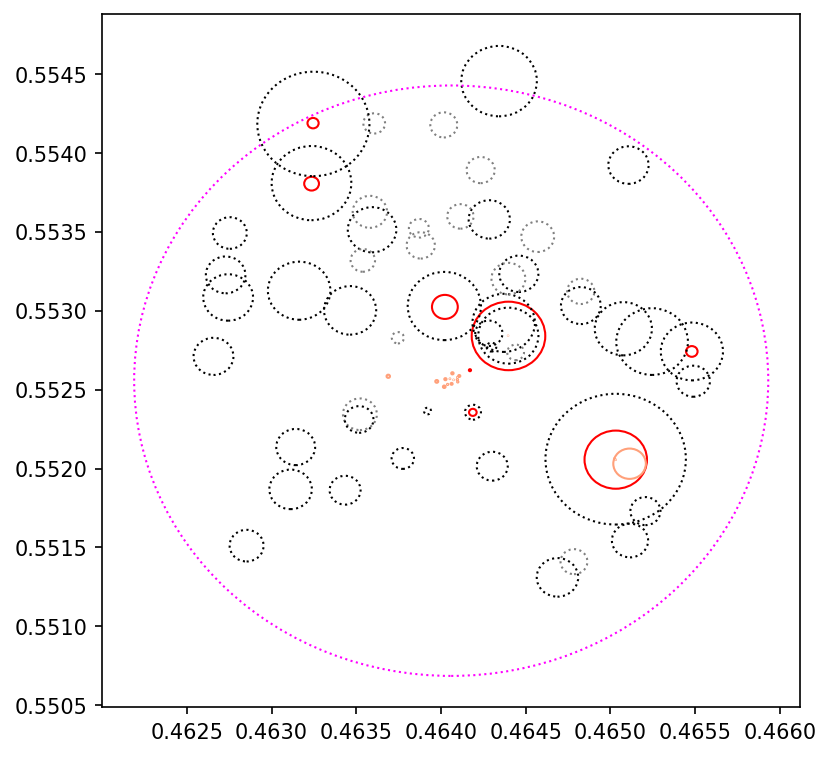

In [51]:
fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=150)
ax.scatter(sats['x'], sats['y'], s=0, c='k')
for sat in sats:
    if(sat['id'] in newsats['id']):
        cir = plt.Circle((sat['x'],sat['y']), sat['r'], color='r', fill=False)
    else:
        cir = plt.Circle((sat['x'],sat['y']), sat['r'], color='lightsalmon', fill=False)
    ax.add_patch(cir)
for sub in subs:
    if(sub['id'] in newsubs['id']):
        cir = plt.Circle((sub['x'],sub['y']), sub['rvir'], color='k', fill=False, ls=':')
    else:
        cir = plt.Circle((sub['x'],sub['y']), sub['rvir'], color='grey', fill=False, ls=':')
    ax.add_patch(cir)

cir = plt.Circle((BGG['x'],BGG['y']), BGG['r200_code']*1.5, color='magenta', fill=False, ls=':')
ax.add_patch(cir)

### Matching

In [52]:
# Initialize
newreals = np.empty(len(newsats)+len(newsubs), dtype=oldLG['real'].dtype)
newreals['hid'] = -1
newreals['gid'] = -1
for i, newsub in enumerate(newsubs):
    newreals[i]['hid'] = newsub['id']
    newreals[i]['state'] = 'dink'
newreals

array([( 5493, -1, 'dink'), (24608, -1, 'dink'), (24611, -1, 'dink'),
       (24613, -1, 'dink'), (24615, -1, 'dink'), (24616, -1, 'dink'),
       (24628, -1, 'dink'), (24630, -1, 'dink'), (24632, -1, 'dink'),
       (24633, -1, 'dink'), (24635, -1, 'dink'), (24636, -1, 'dink'),
       (24639, -1, 'dink'), (24642, -1, 'dink'), (24644, -1, 'dink'),
       (24649, -1, 'dink'), (24650, -1, 'dink'), (24651, -1, 'dink'),
       (24652, -1, 'dink'), (24653, -1, 'dink'), (24657, -1, 'dink'),
       (24658, -1, 'dink'), (24659, -1, 'dink'), (24661, -1, 'dink'),
       (24662, -1, 'dink'), (24664, -1, 'dink'), (24665, -1, 'dink'),
       (24666, -1, 'dink'), (24667, -1, 'dink'), (24668, -1, 'dink'),
       (24669, -1, 'dink'), (24670, -1, 'dink'), (24671, -1, 'dink'),
       (24672, -1, 'dink'), (24673, -1, 'dink'), (24674, -1, 'dink'),
       (   -1, -1, ''), (   -1, -1, ''), (   -1, -1, ''), (   -1, -1, ''),
       (   -1, -1, ''), (   -1, -1, ''), (   -1, -1, ''), (   -1, -1, '')],
      dty

In [53]:
# 1. Both inside center
count = 0
argsort = np.argsort(-newsats['m'])
inewsats = newsats[argsort]
for i, newsat in enumerate(inewsats):
    if(newsat['id'] in newreals['gid']): continue
    already = newreals['hid'][newreals['gid']>0]
    inewsubs = newsubs[~isin(newsubs['id'], already)]
    insides = point_in_sphere(inewsubs, newsat, rname='r', factor=1)
    if(np.sum(insides)==0):
        insides = sphere_in_sphere(newsat, inewsubs, r2='rvir')
    # if(np.sum(insides)==0):
    #     insides = sphere_in_sphere(newsat, inewsubs, r2='r')
    if(np.sum(insides)==0):
        insides1 = sphere_touch_sphere(newsat, inewsubs, r2='rvir')
        insides2 = inewsubs['r']>newsat['r']
        insides = insides1&insides2
    # if(np.sum(insides)==0):
    #     insides = sphere_touch_sphere(newsat, inewsubs, r2='r')
    if(np.sum(insides)==0):
        # orphan
        where = np.where(newreals['hid'] == -1)[0][0]
        newreals[where]['hid'] = 0
        newreals[where]['gid'] = newsat['id']
        newreals[where]['state'] = 'orphan'
    
    cands = inewsubs[insides]
    if(len(cands)==0):
        pass
    elif(len(cands)==1):
        cand = cands[0]
        where = np.where(newreals['hid'] == cand['id'])[0][0]
        newreals[where]['gid'] = newsat['id']; count+=1
        newreals[where]['state'] = 'pair'
    else:
        dists = distance(newsat, cands)
        argmin = np.argmin(dists)
        cand = cands[argmin]
        where = np.where(newreals['hid'] == cand['id'])[0][0]
        newreals[where]['gid'] = newsat['id']; count+=1
        newreals[where]['state'] = 'pair'
print(f"{count}/{len(inewsats)} are matched")

mask = (newreals['hid']>0)|(newreals['gid']>0)
newreals = newreals[mask]
newLG['real'] = newreals

7/8 are matched


In [56]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.scatter(inewsats['x'], inewsats['y'], color='r', s=0)
init_colors()
pairs = newreals[newreals['state']=='pair']
for pair in pairs:
    assert (pair['hid']>0)&(pair['gid']>0)
    sat = newsats[newsats['id']==pair['gid']][0]
    sub = newsubs[newsubs['id']==pair['hid']][0]
    color = get_color()
    cir = plt.Circle((sat['x'], sat['y']), sat['r'], fill=False, ls='-', lw=0.6, color=color)
    ax.add_patch(cir)
    cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], fill=False, ls='--', lw=0.6, color=color)
    ax.add_patch(cir)
    cir = plt.Circle((sub['x'], sub['y']), sub['r'], fill=False, ls=':', lw=0.2, color=color)
    ax.add_patch(cir)
    ax.plot([sat['x'], sub['x']], [sat['y'], sub['y']], color=color, lw=0.6)

cir = plt.Circle((BGG['x'], BGG['y']), BGG['r'], color='k', fill=False)
ax.add_patch(cir)
cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='k', fill=False)
ax.add_patch(cir)
ax.set_aspect(1)
plt.savefig(f"../database/photo/00_data_process/{key:04d}_pairs.png", dpi=300, facecolor='white')
plt.close()

# Add 11 to LocalGroup

In [57]:
LG = pklload("../database/00_LocalGroup.pickle")
LG.keys()

dict_keys([1, 2, 3, 4, 7, 8, 9, 10, 14, 17, 23, 24, 25, 26, 29, 35, 36, 37, 40, 46, 47, 52, 63, 64, 75, 84, 92, 107, 108, 121, 129, 207])

In [59]:
LG[key] = newLG
LG.keys()

dict_keys([1, 2, 3, 4, 7, 8, 9, 10, 14, 17, 23, 24, 25, 26, 29, 35, 36, 37, 40, 46, 47, 52, 63, 64, 75, 84, 92, 107, 108, 121, 129, 207, 11])

In [60]:
pklsave(LG, "../database/00_LocalGroup.pickle", overwrite=True)